In [1]:
import numpy as np
from IPython.display import HTML, display

# periodic boundary conditions


def parse_input(input_str):
    particles = []
    for line in input_str.split("\n"):
        line = line.strip()
        if not line:
            continue

        p, v = line.split(" ")
        p = [int(x) for x in p[2:].split(",")]
        v = [int(x) for x in v[2:].split(",")]
        particles.append((p, v))
    return particles


def to_array(particles, size):
    grid = np.zeros(size, dtype=int)
    for p, _ in particles:
        grid[p[0]][p[1]] += 1
    return grid


def plot_particles(particles, size):
    grid = to_array(particles, size)
    # return numpy array
    # display as html table, in red background when there is a particle
    html = "<table>"
    for row in grid.T:
        html += "<tr>"
        for cell in row:
            if cell:
                html += f"<td style='background-color:red'>{cell}</td>"
            else:
                # cell with a .
                html += "<td>.</td>"
        html += "</tr>"
    html += "</table>"
    display(HTML(html))


In [2]:
def move_point(
    start: tuple[int, int], velocity: tuple[int, int], steps: int, size: tuple[int, int]
) -> tuple[int, int]:
    end = (start[0] + steps * velocity[0], start[1] + steps * velocity[1])
    # periodic boundary conditions
    end = (end[0] % size[0], end[1] % size[1])
    return end


def move_particles(particles, steps, size):
    new_particles = []
    for p, v in particles:
        new_particles.append((move_point(p, v, steps, size), v))
    return new_particles

In [3]:
def count_particles(particles, size):
    h_mid = size[0] // 2
    v_mid = size[1] // 2
    # ul
    ul, ur, dl, dr = 0, 0, 0, 0
    for p, _ in particles:
        if p[0] < h_mid and p[1] < v_mid:
            ul += 1
        elif p[0] > h_mid and p[1] < v_mid:
            ur += 1
        elif p[0] < h_mid and p[1] > v_mid:
            dl += 1
        elif p[0] > h_mid and p[1] > v_mid:
            dr += 1
    print(ul, ur, dl, dr)
    return ul * ur * dl * dr


In [4]:
def simulate_and_count(input_str, size, steps=100, plot=False):
    particles = parse_input(input_str)
    if plot:
        print("Initial state")
        plot_particles(particles, size)
    particles_updated = move_particles(particles, steps, size)
    if plot:
        print(f"After {steps} steps")
        plot_particles(particles_updated, size)
    return count_particles(particles_updated, size)

In [5]:
input_small = """p=0,4 v=3,-3
p=6,3 v=-1,-3
p=10,3 v=-1,2
p=2,0 v=2,-1
p=0,0 v=1,3
p=3,0 v=-2,-2
p=7,6 v=-1,-3
p=3,0 v=-1,-2
p=9,3 v=2,3
p=7,3 v=-1,2
p=2,4 v=2,-3
p=9,5 v=-3,-3"""
with open("input.txt") as f:
    input_large = f.read()

small_size = (11, 7)
large_size = (101, 103)

simulate_and_count(input_small, small_size, plot=True)

Initial state


1,.,1,2,.,.,.,.,.,.,.
.,.,.,.,.,.,.,.,.,.,.
.,.,.,.,.,.,.,.,.,.,.
.,.,.,.,.,.,1,1,.,1,1
1,.,1,.,.,.,.,.,.,.,.
.,.,.,.,.,.,.,.,.,1,.
.,.,.,.,.,.,.,1,.,.,.


After 100 steps


.,.,.,.,.,.,2,.,.,1,.
.,.,.,.,.,.,.,.,.,.,.
1,.,.,.,.,.,.,.,.,.,.
.,1,1,.,.,.,.,.,.,.,.
.,.,.,.,.,1,.,.,.,.,.
.,.,.,1,2,.,.,.,.,.,.
.,1,.,.,.,.,1,.,.,.,.


1 3 4 1


12

In [6]:
simulate_and_count(input_large, large_size, plot=False)

126 135 115 111


217132650

## Second part

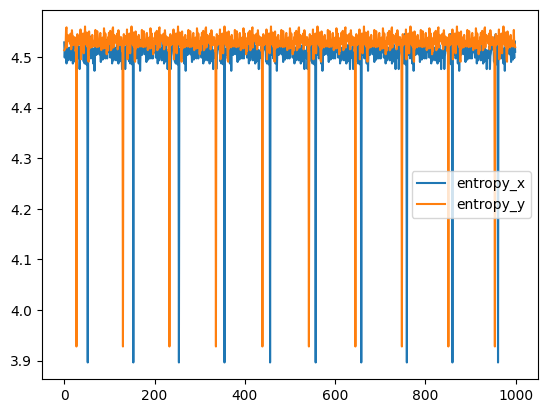

In [78]:
from copy import deepcopy

import matplotlib.pyplot as plt
from scipy.stats import entropy


def simulate(particles, size, steps=100):
    entropies_x = []
    entropies_y = []
    step_list = []
    particles = deepcopy(particles)
    for step in range(steps):
        # entropy of the distributin of values of x and y
        x_values = [p[0][0] for p in particles]
        y_values = [p[0][1] for p in particles]
        frequency_x = np.bincount(x_values)
        entropy_x = entropy(frequency_x)
        frequency_y = np.bincount(y_values)
        entropy_y = entropy(frequency_y)
        entropies_x.append(entropy_x)
        entropies_y.append(entropy_y)
        step_list.append(step)
        particles = move_particles(particles, 1, size)

    return entropies_x, entropies_y, step_list


particles = parse_input(input_large)
entropies_x, entropies_y, steps_list = simulate(particles, large_size, steps=1000)
plt.plot(steps_list, entropies_x, label="entropy_x")
plt.plot(steps_list, entropies_y, label="entropy_y")
plt.legend()
plt.show()

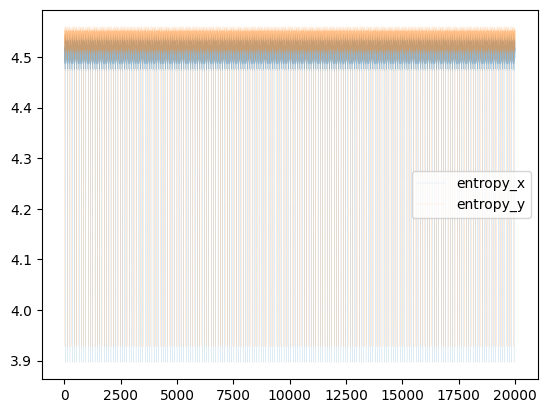

In [79]:
particles = parse_input(input_large)
entropies_x, entropies_y, steps_list = simulate(particles, large_size, steps=20000)
# there are many points, make lines thinner, and use alpha to make them transparent
plt.plot(steps_list, entropies_x, label="entropy_x", linewidth=0.1, alpha=0.5)
plt.plot(steps_list, entropies_y, label="entropy_y", linewidth=0.1, alpha=0.5)
plt.legend()
plt.show()

In [80]:
# x peaks at 100*kx + 52 + kx = 52 + 101*kx
# y peaks at 27 + 103*ky
# common sols if 52 + 101*kx = 27 + 103*ky => 25 = 103*ky - 101*kx
# redefine kx = ky + delta
# 25 = 2*ky - 101*delta => ky = (25 + 101*delta) / 2
# if delta = 1, ky = 63, kx = 64, step = 52 + 101*64 = 6516

peaks_x = [step for step, var in enumerate(entropies_x) if var < 4.4]
peaks_y = [step for step, var in enumerate(entropies_y) if var < 4.4]

common_peaks = set(peaks_x) & set(peaks_y)
print(common_peaks)
step_match = min(common_peaks)
print(step_match)

{6516, 16919}
6516


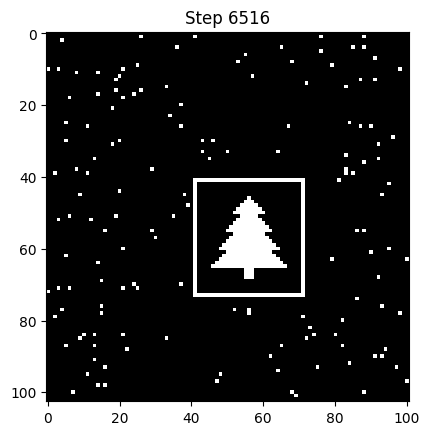

In [81]:
particles = parse_input(input_large)

particles_new = move_particles(particles, steps=step_match, size=large_size)
grid = to_array(particles_new, large_size)
plt.title(f"Step {step_match}")
plt.imshow(grid.T, cmap="gray")